In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
import statsmodels.api as sm

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
df = pd.read_csv('saas.csv')
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [4]:
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df = df.rename(columns={'month_invoiced': 'invoice_date'})

In [7]:
df = df.set_index('invoice_date')

In [8]:
df.sort_index()

,customer_id,invoice_id,subscription_type,amount
invoice_date,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [9]:
df.head()

,customer_id,invoice_id,subscription_type,amount
invoice_date,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [10]:
df = df.drop(['customer_id','invoice_id'], axis=1)

In [11]:
df2 = df.copy()

# Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [12]:
# Percent-Based Split (55/25/20)
train_len = int(0.55 * len(df))
val_test_split = int(0.8 * len(df))
train_len, val_test_split

(434751, 632366)

In [13]:
# Train set. Everything up to train_len
train = df.iloc[:train_len]

# Val set. Everything between train_len & val_test_split
val = df.iloc[train_len:val_test_split]

# Test set. Everything after val_test_split
test = df.iloc[val_test_split:]
train.shape, val.shape, test.shape

((434751, 2), (197615, 2), (158092, 2))

In [14]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
subscription_type,434751.0,0.507622,0.900888,0.0,0.0,0.0,1.0,4.0
amount,434751.0,2.538108,4.504438,0.0,0.0,0.0,5.0,20.0


In [15]:
train.subscription_type.value_counts()

0.0    296953
1.0     84868
2.0     32207
3.0     11485
4.0      9238
Name: subscription_type, dtype: int64

<AxesSubplot:xlabel='subscription_type'>

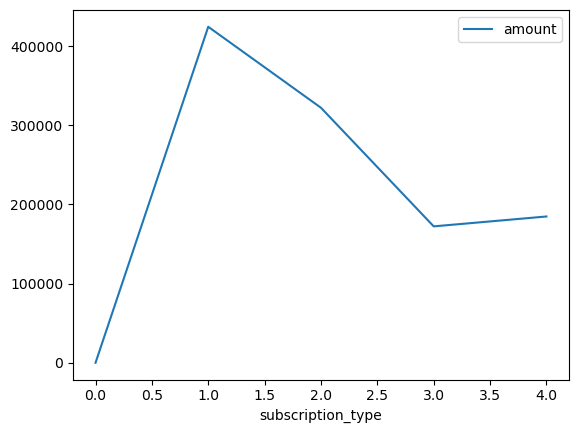

In [16]:
train.groupby('subscription_type').sum().plot()

<AxesSubplot:xlabel='subscription_type', ylabel='amount'>

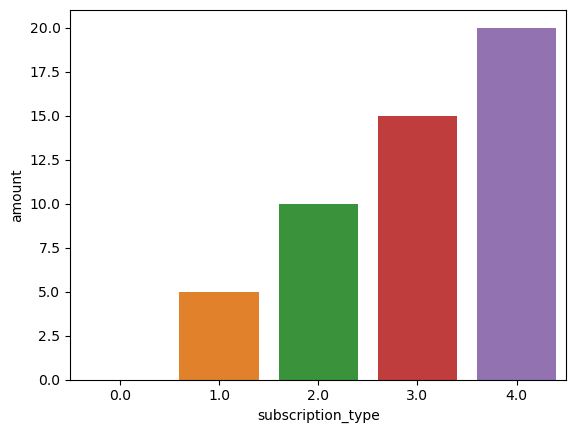

In [17]:
sns.barplot(x='subscription_type', y='amount', data=train)

## Last Observed Value

In [18]:
train.head(3)

,subscription_type,amount
invoice_date,,
2014-01-31,0.0,0.0
2014-01-31,2.0,10.0
2014-01-31,0.0,0.0


### Create predictions df(yhat)

In [19]:
# Last amount
last_amount = train['amount'][-1]
last_sub = train['subscription_type'][-1]

In [33]:
yhat_df = pd.DataFrame({'amount': last_amount,
                       'subscription_type': last_sub}, index= val.index)
yhat_df.head()

,amount,subscription_type
invoice_date,,
2016-01-31,5.0,1.0
2016-01-31,5.0,1.0
2016-01-31,5.0,1.0
2016-01-31,5.0,1.0
2016-01-31,5.0,1.0


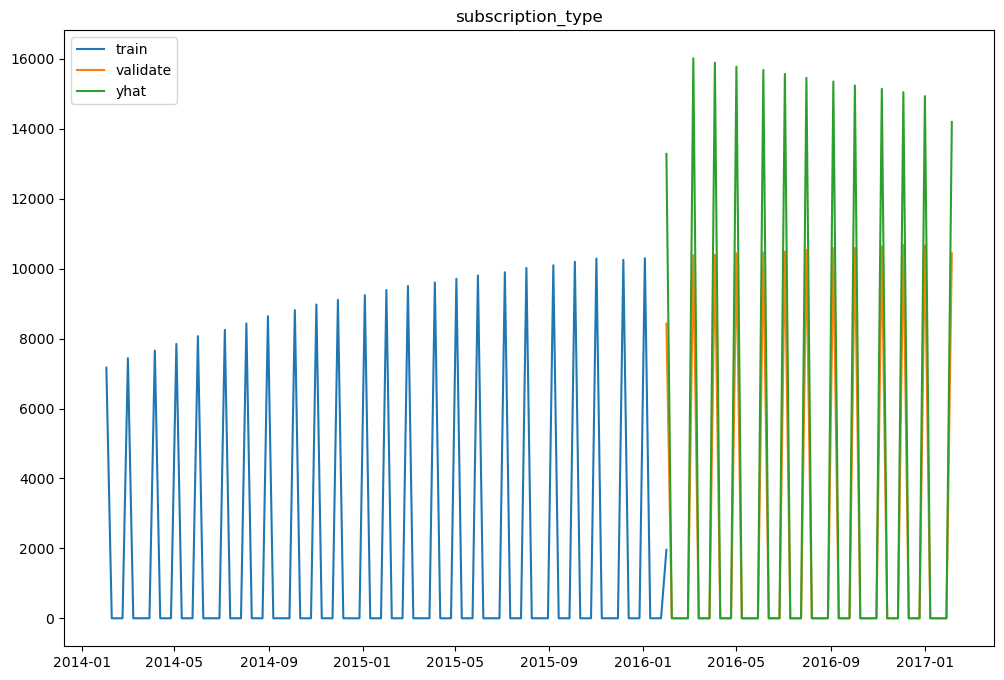

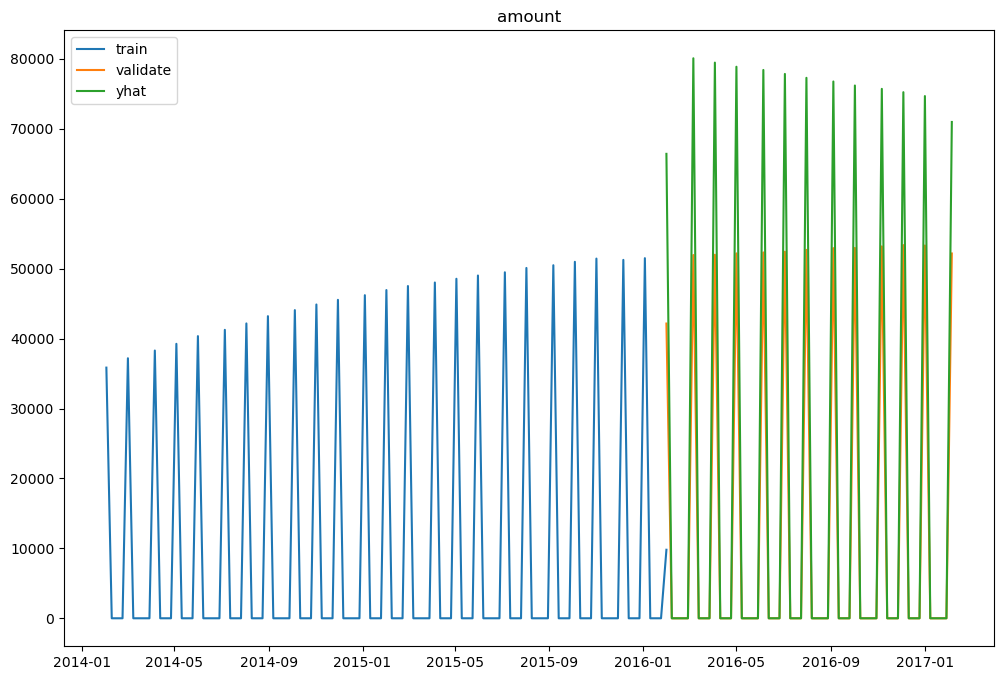

In [54]:
for col in train.columns:
    
    plt.figure(figsize=(12,8))
    plt.plot(train[col].resample('W').sum(), label='train')
    plt.plot(val[col].resample('W').sum(), label='validate')
    plt.plot(yhat_df[col].resample('W').sum(), label='yhat')
    plt.legend()
    plt.title(col)
    plt.show()
    

## Moving Average

In [55]:
# Rolling average of last 60 days
rolling = train['amount'].rolling(60).mean()[-1]
rolling

2.9166666666666665

In [59]:
yhat_df = pd.DataFrame({'amount': rolling,
                       'subscription_type': val.subscription_type}, index= val.index)
yhat_df.head(3)

,amount,subscription_type
invoice_date,,
2016-01-31,2.916667,0.0
2016-01-31,2.916667,1.0
2016-01-31,2.916667,1.0


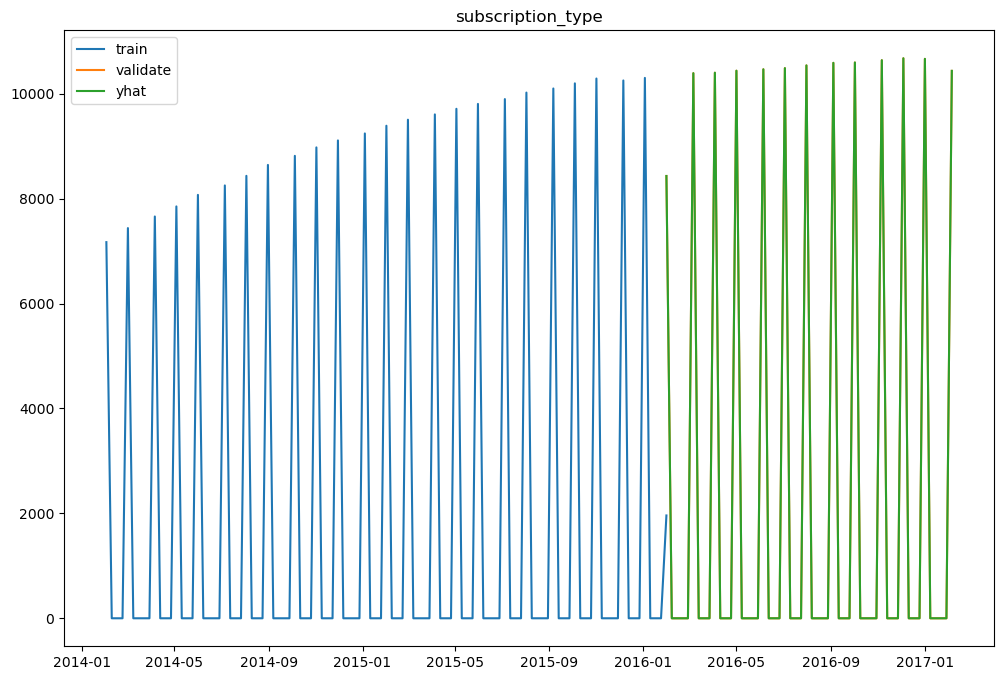

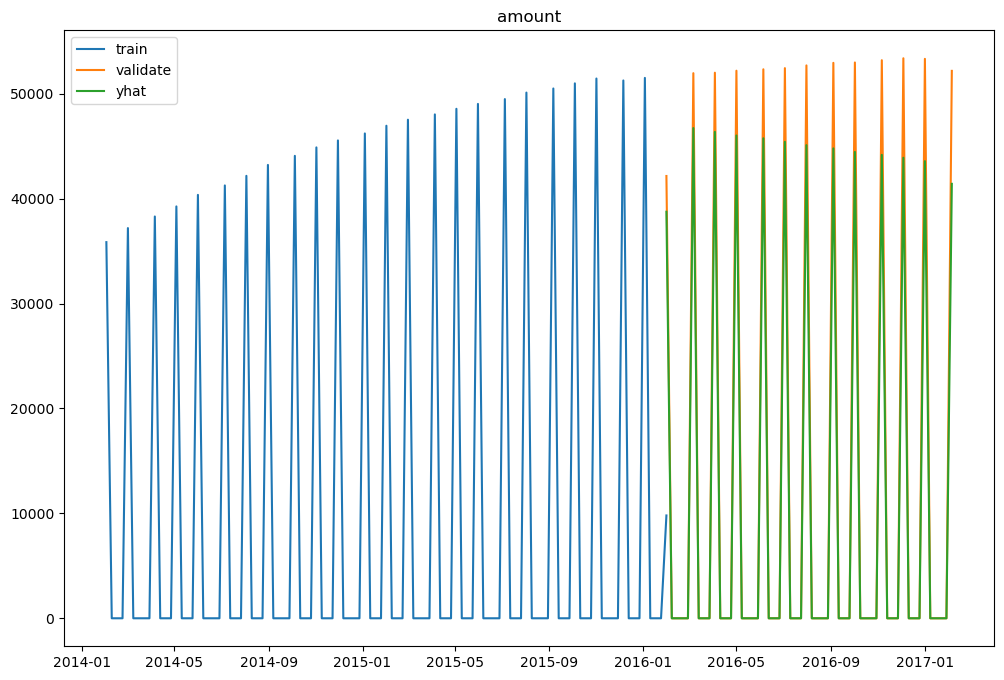

In [60]:
for col in train.columns:
    
    plt.figure(figsize=(12,8))
    plt.plot(train[col].resample('W').sum(), label='train')
    plt.plot(val[col].resample('W').sum(), label='validate')
    plt.plot(yhat_df[col].resample('W').sum(), label='yhat')
    plt.legend()
    plt.title(col)
    plt.show()

## Holt's Linear Trend

In [71]:
# Holt Object
model = Holt(train.amount, exponential=False, damped=True)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [72]:
# fit the Holt object
model = model.fit(optimized=True)

In [103]:
yhat_amount = model.predict(start = train.index[0], end = train.index[-1])

Timestamp('2017-01-31 00:00:00')

## Based on previous year/month/etc., this is up to you.

In [88]:
df.index.max(), df.index.min()

(Timestamp('2017-12-31 00:00:00'), Timestamp('2014-01-31 00:00:00'))

In [89]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

train.shape, validate.shape, test.shape

((431894, 2), (186275, 2), (172289, 2))

In [90]:
train.diff(30).mean()

subscription_type   -0.000016
amount              -0.000081
dtype: float64

In [100]:
yhat_df = train['2015'] + train.diff(30).mean()

In [101]:
yhat_df

,subscription_type,amount
invoice_date,,
2015-01-31,-0.000016,-0.000081
2015-01-31,1.999984,9.999919
2015-01-31,-0.000016,-0.000081
2015-01-31,0.999984,4.999919
2015-01-31,1.999984,9.999919
...,...,...
2015-12-31,-0.000016,-0.000081
2015-12-31,-0.000016,-0.000081
2015-12-31,-0.000016,-0.000081


In [96]:
yhat_df.index = validate.index

ValueError: Length mismatch: Expected axis has 204352 elements, new values have 186275 elements

In [93]:
pd.concat([yhat_df.head(1), validate.head(1)])

,subscription_type,amount
invoice_date,,
2015-01-31,-0.000016,-0.000081
2016-01-31,1.000000,5.000000


In [94]:
yhat_df.shape

(204352, 2)

In [95]:
validate.shape # A leap year!

(186275, 2)